#Introduction:

The goal of this Notebook is to use GLMs to predict how many auto claims are filed based on a Kaggle dataset from 677,991 french policy holders

Import Libraries

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

Upload the Dataset

In [173]:
from google.colab import files

files.upload()

df = pd.read_csv('/content/freMTPL2freq.csv')
df.head()



,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


Our Target is the ClaimNb category.

#Preliminary Data Analysis and Preprocessing

<Axes: xlabel='ClaimNb', ylabel='Count'>

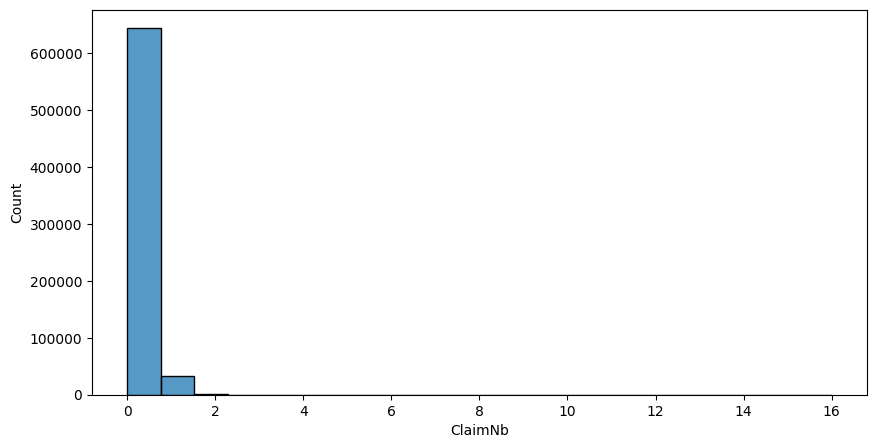

In [174]:
plt.figure(figsize = (10, 5))
sns.histplot(data = df, x ='ClaimNb')

We see the claim frequenies resemble a poisson distribution with mean zero. This is a common policy plan structure in insurance where majority of the policy holders file 0 claims per year. The frequency characteristic of the category would imply that it's best to use a poisson regression glm.

Next, process categorical variables into numerical categories to make them easier to work with.

In [175]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

non_numeric_columns = df.select_dtypes(include = ['category', 'object']).columns
for col in non_numeric_columns:
  df[col] = le.fit_transform(df[col])

df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,3,5,0,55,50,3,1,1217,17
1,3.0,1,0.77,3,5,0,55,50,3,1,1217,17
2,5.0,1,0.75,1,6,2,52,50,3,0,54,2
3,10.0,1,0.09,1,7,0,46,50,3,0,76,14
4,11.0,1,0.84,1,7,0,46,50,3,0,76,14


Creat a correlation heatmap

<Axes: >

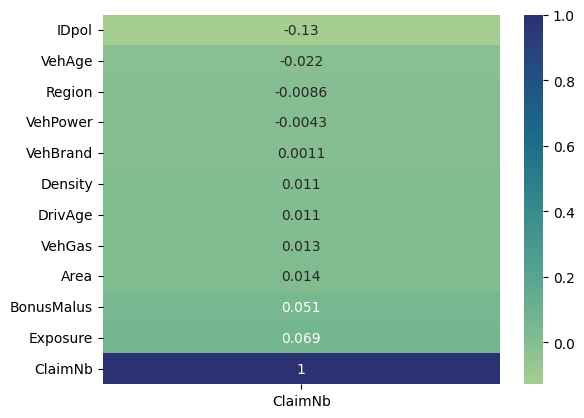

In [176]:
correlations = df.corr()['ClaimNb'].sort_values(ascending=True)
sns.heatmap(correlations.to_frame(), cmap = 'crest', annot = True)

Observe weak correlation between features and target.

<Axes: >

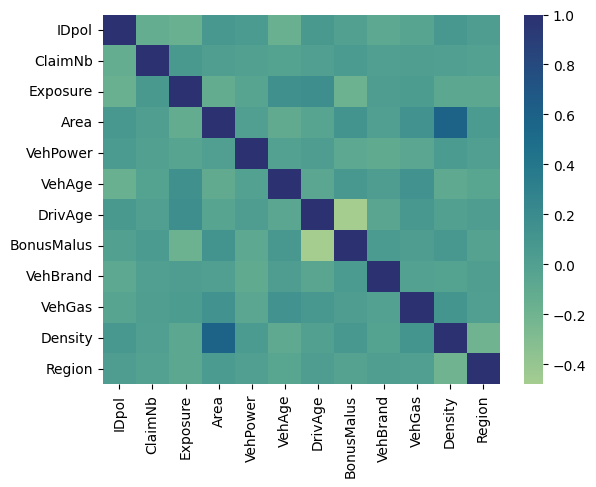

In [177]:
sns.heatmap(df.corr(), cmap = 'crest')

Initialize our target and features, then begin feature selection.

In [178]:
X = df.drop(['ClaimNb','IDpol'], axis = 1) #We also drop the Policy ID since that provides no value in predicting claims
y = df['ClaimNb']

Scale our features for better results in training and feature selection

In [179]:
from sklearn.preprocessing import StandardScaler

#Scale our Data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [193]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import PoissonRegressor

#Begin recursive feature elimination
pr = PoissonRegressor()
rfecv = RFECV(estimator=pr, step=1, cv=StratifiedKFold(5), scoring='neg_mean_squared_error')
rfecv.fit(X, y)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=PoissonRegressor(), scoring='neg_mean_squared_error')

In [194]:
#print('Op[timal number of features: {}'.format(rfecv.n_features_))
X[X.columns[rfecv.support_]]
X = df[X.columns[rfecv.support_]]
X.head()

,Exposure,BonusMalus
0,0.10,50
1,0.77,50
2,0.75,50
3,0.09,50
4,0.84,50


According to recursive feature elimination with cross validation, we choose exposure period (how far into a one year coverage a policyholder has been covered) and Bonus/Malus (premium penalty or discount based on policy holder's previous claim history classification <100 = Bonus, >100 = Malus) as the most optimal subset of features to perform poisson regression on.

#Poisson regression

In [188]:
from sklearn.model_selection import train_test_split

#Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#train the model
pr.fit(X_train, y_train)

PoissonRegressor()

Plot the residuals

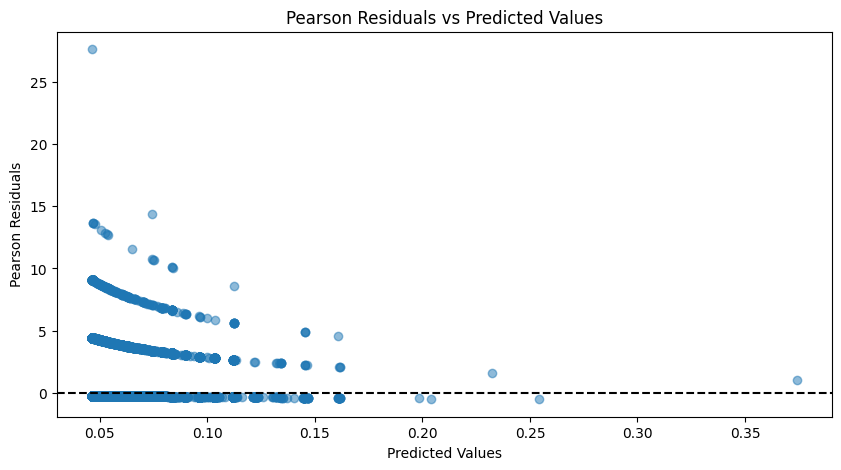

In [189]:
#Makes predictions based on test set
y_pred = pr.predict(X_test)
plt.figure(figsize=(10, 5))

#Plot the Pearson Residuals
pearson_residuals = (y_test - y_pred) / np.sqrt(y_pred)
plt.scatter(y_pred, pearson_residuals, alpha=0.5)
plt.title("Pearson Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Pearson Residuals")
plt.axhline(0, color='black', linestyle='--')


<Axes: ylabel='Count'>

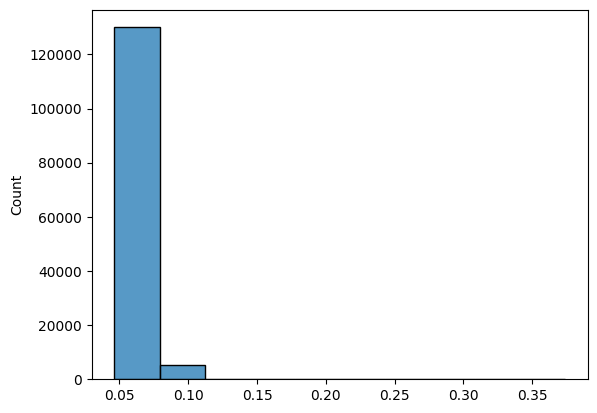

In [190]:
sns.histplot(data = y_pred, bins = 10)

Model evaluation

In [196]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_poisson_deviance

#Calculate Performance Metrics:
Explained_variance = explained_variance_score(y_test, y_pred)
mpd = mean_poisson_deviance(y_test, y_pred)

#Print Metrics for model evaluations
print("Model Metrics:")
print(f"Explained Variance: {Explained_variance}")
print(f"Mean Poisson Deviance: {mpd}")

Model Metrics:
Explained Variance: 0.002901503190333332
Mean Poisson Deviance: 0.3187005137182884


#Model Conclusions:

By not running the feature selection cells we can see if recursive feature elimination added value to our model.

-Explained variance with recursive feature elimination: 0.002901503190333332

-Explained variance without recursive feature elimination: 0.0007513813039160544

Thus our model captured more variance thanks to our feature selection algorithm choice.


In [192]:
#Amount of times of improved variance
0.002901503190333332/0.0007513813039160544

3.861558938466072

Therfore, Recursive feature elimination increased our explained variance by 3.86 times